In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
import tensorflow as tf
import os, shutil
import json

gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, False)
    
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=8192)])  
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPU


In [8]:


from google.colab import drive
drive.mount('/content/drive')
! cp drive/MyDrive/utils.py ./
! cp drive/MyDrive/training_data ./ -R

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#imgSet = pd.read_csv('train.csv')
import utils

imageFolder = 'train_images'
seed = 1234
sample_fraction = 0.2


labelDataPath = "label_num_to_disease_map.json"
#imgSet.plot.hist(by='label');

image_width = utils.TEST_IMG_SIZE
image_height = utils.TEST_IMG_SIZE
batch_size = 32
epochs=15
num_classes = 5

#limitedModelSet = imgSet.sample(frac=sample_fraction, random_state=seed)

trainingDir = "training_data"

# num_classes = 0
# with open(labelDataPath, 'r') as jsonFile:
#     labelData = json.load(jsonFile)
    
#     if os.path.exists(trainingDir):
#         utils.clean_folder(trainingDir)
#     else:
#         os.mkdir(trainingDir)
    
#     num_classes = len(labelData)
    
#     for key in labelData:
#         os.mkdir(trainingDir + '/' + key)
        
#     for i in limitedModelSet.index:
#         img_id = limitedModelSet['image_id'][i]
#         label = limitedModelSet['label'][i]
        
#         shutil.copyfile(imageFolder + '/' + img_id, trainingDir + '/' + str(label) + '/' + img_id)
        

        
plantDataSet = keras.utils.image_dataset_from_directory(trainingDir, batch_size = batch_size, image_size = (image_height,image_width),
  validation_split=0.2,
  subset="training",
  seed=seed)

validationDataSet = keras.utils.image_dataset_from_directory(trainingDir, batch_size = batch_size, image_size = (image_height,image_width),
  validation_split=0.2,
  subset="validation",
  seed=seed)



for images, labels in plantDataSet.take(1):
    print("Image batch shape:", images.shape)
    print("Image label shape:", labels.shape)


grayscale = layers.Rescaling(1./255, input_shape=(image_height, image_width, 3))


filter_nan = lambda x, y: not tf.reduce_any(tf.math.is_nan(x)) and not tf.math.is_nan(y)

AUTOTUNE = tf.data.AUTOTUNE
plantDataSet = plantDataSet.map(lambda x,y: (grayscale(x),y), num_parallel_calls= tf.data.AUTOTUNE).shuffle(200)
validationDataSet = validationDataSet.map(lambda x,y: (grayscale(x),y), num_parallel_calls= tf.data.AUTOTUNE)
 

testModel = Sequential([
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(192, activation='relu', kernel_regularizer=regularizers.L1L2(1e-4, 1e-5)),
    layers.Dense(num_classes)
])


#testModel.build(input_shape=(utils.TEST_IMG_SIZE, utils.TEST_IMG_SIZE, 3, 1));

opt = tf.keras.optimizers.RMSprop()
adamOpt = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.99)

testModel.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Found 4279 files belonging to 5 classes.
Using 3424 files for training.
Found 4279 files belonging to 5 classes.
Using 855 files for validation.
Image batch shape: (32, 400, 400, 3)
Image label shape: (32,)


In [3]:
history = testModel.fit(
  plantDataSet,
  validation_data=validationDataSet,
  epochs=epochs
)

Epoch 1/15
107/107 [==============================] - 57s 258ms/step - loss: 3.9779 - accuracy: 0.5873 - val_loss: 2.8078 - val_accuracy: 0.6339
Epoch 2/15
107/107 [==============================] - 42s 250ms/step - loss: 2.8005 - accuracy: 0.6040 - val_loss: 2.6694 - val_accuracy: 0.6339
Epoch 3/15
107/107 [==============================] - 41s 250ms/step - loss: 2.7520 - accuracy: 0.6066 - val_loss: 2.7110 - val_accuracy: 0.6374
Epoch 4/15
107/107 [==============================] - 41s 250ms/step - loss: 2.7365 - accuracy: 0.6148 - val_loss: 2.8178 - val_accuracy: 0.6374
Epoch 5/15
107/107 [==============================] - 40s 248ms/step - loss: 2.7082 - accuracy: 0.6101 - val_loss: 2.6181 - val_accuracy: 0.6386
Epoch 6/15
107/107 [==============================] - 41s 248ms/step - loss: 2.6622 - accuracy: 0.6171 - val_loss: 2.5989 - val_accuracy: 0.6468
Epoch 7/15
107/107 [==============================] - 40s 249ms/step - loss: 2.6372 - accuracy: 0.6250 - val_loss: 2.6330 - val_ac

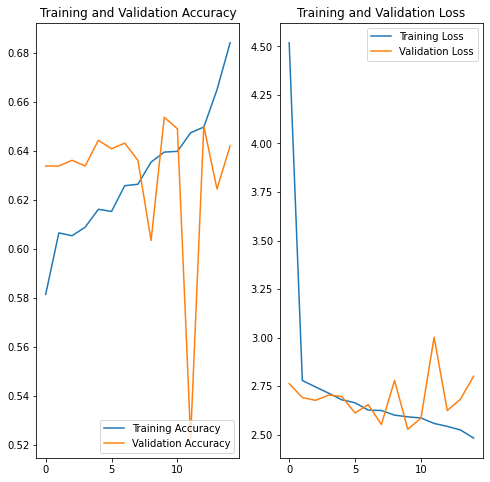

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
testModel.save('leaf_disease_save')

In [13]:
! cp ./leaf_disease_save drive/MyDrive/leaf_disease_save  -R